<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [40]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [41]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2), nn.ReLU()) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [42]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

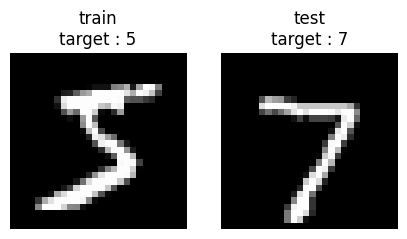

In [43]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [44]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=10)

train_loader = DataLoader(train_data, batch_size=20000, shuffle=True)


In [45]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.9)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1052.0234985351562
Epoch :  2   -----------> Loss :  827.7170003255209
Epoch :  3   -----------> Loss :  621.1358642578125
Epoch :  4   -----------> Loss :  441.119873046875
Epoch :  5   -----------> Loss :  294.05559794108075
Epoch :  6   -----------> Loss :  182.24865214029947
Epoch :  7   -----------> Loss :  104.58907063802083
Epoch :  8   -----------> Loss :  57.91731516520182
Epoch :  9   -----------> Loss :  36.89993413289388
Epoch :  10   -----------> Loss :  35.310550689697266
Epoch :  11   -----------> Loss :  47.58687210083008
Epoch :  12   -----------> Loss :  67.76084391276042
Epoch :  13   -----------> Loss :  90.35463460286458
Epoch :  14   -----------> Loss :  111.53038279215495
Epoch :  15   -----------> Loss :  128.57545216878256
Epoch :  16   -----------> Loss :  140.45726013183594
Epoch :  17   -----------> Loss :  147.21778361002603
Epoch :  18   -----------> Loss :  149.4823760986328
Epoch :  19   -----------> Loss :  148.68007405

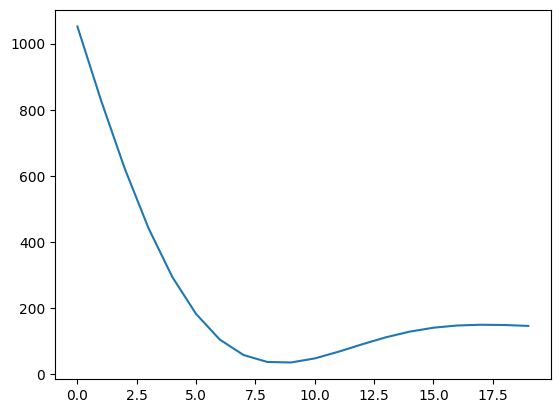

In [46]:
plt.plot(COST)

In [47]:
test = prior.sample((50,))
test

tensor([[ 0.5818, -0.8978, -0.6154,  ..., -0.3468,  0.5008, -0.2140],
        [ 0.2487,  0.4590, -0.2510,  ..., -0.2830,  1.7152,  1.4138],
        [ 0.7879,  0.8705,  1.3750,  ...,  2.6246,  0.3206,  2.0369],
        ...,
        [-0.4919,  0.1184,  0.0703,  ...,  0.7632, -0.5002,  0.0561],
        [-0.0156,  1.5286,  0.4000,  ...,  0.0631, -0.6359,  0.1819],
        [-0.6367,  0.6273,  0.7008,  ...,  0.1035, -1.4404, -0.1058]])

In [48]:
sonuc = model.f_inv(test)


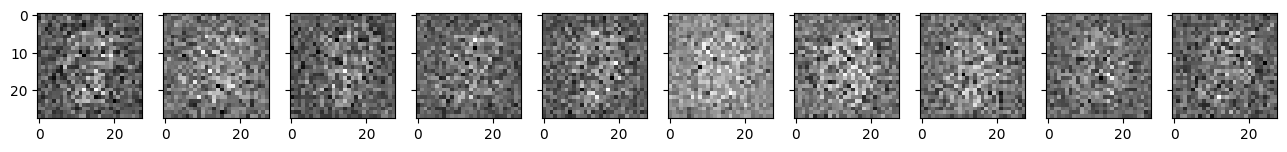

In [49]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(sonuc[i].detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()